# Workshop3: Fine-tuning Mistral Small 24B with QLoRA

Welcome to this hands-on workshop! By the end of this session, you'll have fine-tuned a Mistral Small 24B model for medical diagnosis and deployed it as a custom model in Amazon Bedrock.

### What You'll Learn:
- Fine-tuning large language models with QLoRA (Quantized LoRA)
- Working with medical datasets for AI training
- Preparing models for Amazon Bedrock Custom Model Import
- Comparing base vs fine-tuned model performance

### Prerequisites:
- AWS account with Bedrock access
- SageMaker Studio or similar GPU environment
- Basic understanding of machine learning concepts

## Workshop Overview:
1. **Environment Setup** - Install dependencies and configure environment
2. **Data Preparation** - Load and prepare medical training data
3. **Model Loading** - Load quantized Mistral Small 24B model
4. **QLoRA Configuration** - Set up efficient fine-tuning adapters
5. **Training** - Fine-tune the model on medical data
6. **Evaluation** - Compare base vs fine-tuned performance
7. **Model Preparation** - Prepare for Bedrock deployment

<mark>Note: We don't fine-tune the model during the workshop. If you want to fine-tune the model later offline, recommended configurations are:</mark>
- **Instance Type**: `ml.g5.48xlarge` or similar (8 A10G GPUs, 24GB GPU memory each)
- **Alternative**: `ml.g6.16xlarge` (1 NVIDIA L4 GPUs, 24 GB GPU memory) 
- **Environment**: SageMaker Studio with Python 3 kernel

## Step 1: Environment Setup & Prerequisites

Let's start by setting up our environment and understanding our tools:

### Dataset Information:
We'll use the **BI55/MedText** dataset, which contains medical prompts and completions for training a medical AI assistant.

### Hugging Face Setup:
1. Get access to [Mistral Small 24B Instruct](https://huggingface.co/mistralai/Mistral-Small-24B-Instruct-2501)
2. Create a [Hugging Face API token](https://huggingface.co/docs/hub/en/security-tokens) with READ permissions
3. Login using `notebook_login()`

In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Install Required Libraries

In [2]:
!pip3 install -qU accelerate>=1.6.0
!pip3 install -qU torch bitsandbytes transformers==4.46.3 peft datasets
!pip3 install -qU tensorboardX

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.3.0 requires nvidia-ml-py3<8.0,>=7.352.0, which is not installed.
autogluon-multimodal 1.3.0 requires transformers[sentencepiece]<4.50,>=4.38.0, but you have transformers 4.51.3 which is incompatible.
autogluon-timeseries 1.3.0 requires coreforecast<0.0.16,>=0.0.12, but you have coreforecast 0.0.16 which is incompatible.
autogluon-timeseries 1.3.0 requires transformers[sentencepiece]<4.50,>=4.38.0, but you have transformers 4.51.3 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
amazon-sagemaker-jupyter-ai-q-developer 1.2.4 requires onnxruntime<2,>=1.15.0, which is not installed.
autogluon-multimodal 1.3.0 requires nvidia-ml-py3<8.0,>=7.352.0, w

In [4]:
# Add installed cuda runtime to path for bitsandbytes 
import nvidia
import os

cuda_install_dir = '/'.join(nvidia.__file__.split('/')[:-1]) + '/cuda_runtime/lib/'
os.environ['LD_LIBRARY_PATH'] =  cuda_install_dir

## Step 2: Load and Prepare Medical Dataset

In [5]:
# Load the medical dataset and split into train/validation/test sets
from datasets import load_dataset
import torch

print("🏥 Loading medical dataset...")
dataset = load_dataset("BI55/MedText", split="train")

# Split into 80% train, 10% validation, 10% test
split_1 = dataset.train_test_split(test_size=0.2, seed=42)
split_2 = split_1['test'].train_test_split(test_size=0.5, seed=42)

train_set = split_1['train']
validation_set = split_2['train']
test_set = split_2['test']

print(f"✅ Dataset loaded successfully!")

🏥 Loading medical dataset...
✅ Dataset loaded successfully!


In [9]:
# Let's examine our dataset structure
print("🔍 Dataset structure:")
print(f"   Features: {train_set.features}")
print(f"\n📋 Sample data point:")
print(f"   Prompt: {train_set[0]['Prompt']}")
print(f"   Completion: {train_set[0]['Completion']}")

🔍 Dataset structure:
   Features: {'Prompt': Value(dtype='string', id=None), 'Completion': Value(dtype='string', id=None)}

📋 Sample data point:
   Prompt: A 16-year-old male presents with multiple blackheads and red bumps on his forehead, cheeks, and nose. He mentions they have been persisting for about a year, and he feels his skin is quite oily. What could be the potential cause, and what would be the treatment plan?
   Completion: This patient is likely suffering from moderate acne vulgaris, characterized by a mix of open comedones (blackheads) and inflammatory lesions (red bumps). Acne vulgaris is common during adolescence due to increased sebum production, prompted by hormonal changes. The first line of treatment includes topical retinoids, which help unclog pores, and topical antimicrobials such as benzoyl peroxide or clindamycin to reduce bacterial growth and inflammation.


## Step 3: Load Quantized Mistral Small 24B Model

In [5]:
# Load the quantized model with 4-bit precision for efficient training
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

print("🚀 Loading Mistral Small 24B model...")
model_id = "mistralai/Mistral-Small-24B-Instruct-2501"

# Configure 4-bit quantization for memory efficiency
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model with quantization
model = AutoModelForCausalLM.from_pretrained(
    model_id, 
    quantization_config=bnb_config, 
    device_map="auto", 
    cache_dir="/home/sagemaker-user/model_cache"  # Use NVMe storage for caching
)

print("✅ Model loaded successfully!")


🚀 Loading Mistral Small 24B model...


2025-06-13 12:58:16.934719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749819496.945856    2787 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749819496.949327    2787 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-13 12:58:16.961086: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

✅ Model loaded successfully!


In [6]:
!df -h

Filesystem                             Size  Used Avail Use% Mounted on
overlay                                 37G  5.3G   32G  15% /
tmpfs                                   64M     0   64M   0% /dev
tmpfs                                   61G     0   61G   0% /sys/fs/cgroup
shm                                     16G   80K   16G   1% /dev/shm
/dev/mapper/sagemaker_vg-sagemaker_lv  838G   50G  788G   6% /mnt/sagemaker-nvme
/dev/nvme0n1p1                         180G   31G  150G  17% /usr/bin/nvidia-smi
/dev/nvme3n1                           100G   49G   52G  49% /home/sagemaker-user
127.0.0.1:/                            8.0E     0  8.0E   0% /mnt/custom-file-systems/efs/fs-09badb99b5c560bea_fsap-0c61ab2cee099341a
tmpfs                                   61G   12K   61G   1% /proc/driver/nvidia
tmpfs                                   61G  1.3M   61G   1% /run/nvidia-persistenced/socket
tmpfs                                   61G     0   61G   0% /proc/acpi
tmpfs                        

## Step 4: Tokenization and Data Preprocessing

In [8]:
# Load tokenizer for text processing
print("🔤 Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(
    model_id, 
    add_eos_token=True,    # End Of Sentence Token
    add_bos_token=True     # Beginning Of Sentence Token
)
print("✅ Tokenizer loaded successfully!")

🔤 Loading tokenizer...


NameError: name 'AutoTokenizer' is not defined

### Format Training Data
We need to format our medical data with a consistent prompt template for training:

In [8]:
# Tokenization function
def tokenize(prompt):
    result = tokenizer(prompt)
    result["labels"] = result["input_ids"].copy()   # Setting labels = input_ids for causal LM
    return result

In [9]:
# Format data with medical prompt template
def generate_and_tokenize_prompt(data_point):
    full_prompt = f"""You are a medical professional. Given a prompt of a user with different symptoms, provide a diagnosis.

    ### Prompt:
    {data_point["Prompt"]}
    
    ### Response:
    {data_point["Completion"]}
    """
    return tokenize(full_prompt)

In [10]:
# Apply tokenization to our datasets
print("🔄 Tokenizing datasets...")
tokenized_train_dataset = train_set.map(generate_and_tokenize_prompt)
tokenized_validation_dataset = validation_set.map(generate_and_tokenize_prompt)
print("✅ Tokenization complete!")

🔄 Tokenizing datasets...


Map:   0%|          | 0/1129 [00:00<?, ? examples/s]

Map:   0%|          | 0/141 [00:00<?, ? examples/s]

✅ Tokenization complete!


## Step 5: Analyze Token Lengths & Set Padding

### Visualize Token Length Distribution
Understanding our data's token lengths helps us set appropriate padding:

In [11]:
# Visualize token length distribution
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_validation_dataset):
    lengths1 = [len(x["input_ids"]) for x in tokenized_train_dataset]
    lengths2 = [len(x["input_ids"]) for x in tokenized_validation_dataset]
    lengths = lengths1 + lengths2
    
    plt.figure(figsize=(10,6))
    plt.hist(lengths, bins=20, alpha=0.7, color="blue")
    plt.xlabel("Token Length")
    plt.ylabel("Frequency")
    plt.title("Distribution of Input Token Lengths")
    plt.show()
    
    print(f"📊 Max token length: {max(lengths)}")
    print(f"📊 Average token length: {sum(lengths)/len(lengths):.1f}")
    
    return max(lengths)

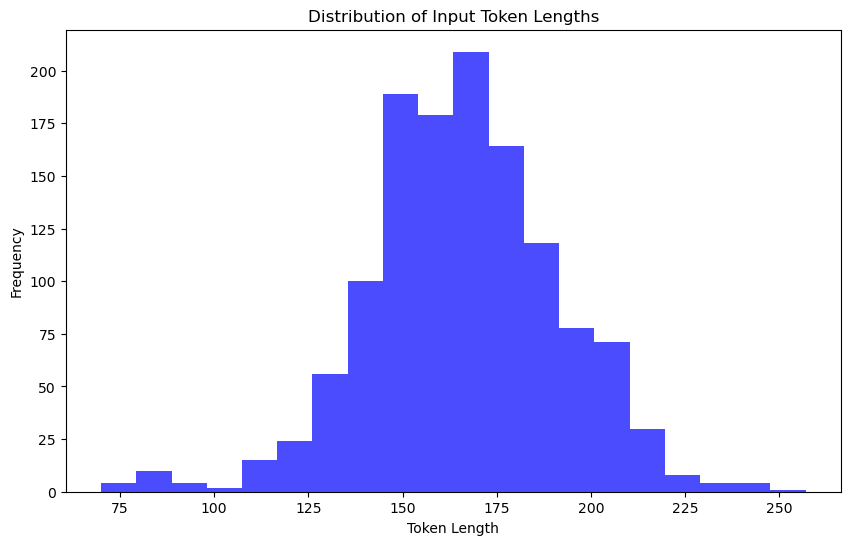

📊 Max token length: 257
📊 Average token length: 166.1
🎯 Using max length: 257 tokens


In [12]:
# Get maximum length and visualize distribution
max_length = plot_data_lengths(tokenized_train_dataset, tokenized_validation_dataset)

# Alternative: Direct calculation of max length
# max_length = max([len(x["input_ids"]) for x in tokenized_train_dataset])
print(f"🎯 Using max length: {max_length} tokens")

### Configure Tokenizer with Padding
Now we'll set up padding to ensure all inputs are the same length:

In [7]:
# Reconfigure tokenizer with padding
tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    padding_side="right",
    add_eos_token=True,
    add_bos_token=True
)
tokenizer.pad_token = tokenizer.eos_token    # Use EOS token as pad token

print(f"✅ Tokenizer configured with padding to {max_length} tokens")

NameError: name 'AutoTokenizer' is not defined

In [14]:
# Updated tokenization function with padding
def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=max_length,
        padding="max_length"
    )
    result["labels"] = result["input_ids"].copy()
    return result

# Re-tokenize datasets with padding
print("🔄 Re-tokenizing datasets with padding...")
tokenized_train_dataset = train_set.map(generate_and_tokenize_prompt)
tokenized_validation_dataset = validation_set.map(generate_and_tokenize_prompt)
print("✅ Padded tokenization complete!")

🔄 Re-tokenizing datasets with padding...


Map:   0%|          | 0/1129 [00:00<?, ? examples/s]

Map:   0%|          | 0/141 [00:00<?, ? examples/s]

✅ Padded tokenization complete!


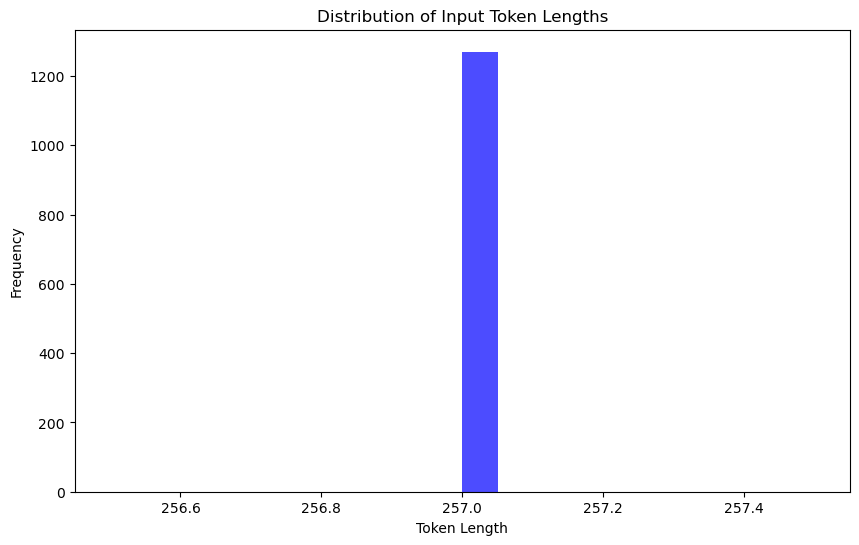

📊 Max token length: 257
📊 Average token length: 257.0


257

In [15]:
# Verify all tokens are now the same length
plot_data_lengths(tokenized_train_dataset, tokenized_validation_dataset)

## Step 6: Configure QLoRA (Quantized LoRA)

In [16]:
# Prepare model for QLoRA fine-tuning
from peft import prepare_model_for_kbit_training

print("⚙️ Preparing model for QLoRA training...")
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)
print("✅ Model prepared for training!")

⚙️ Preparing model for QLoRA training...
✅ Model prepared for training!


In [17]:
# Helper function to check trainable parameters
def print_trainable_parameters(model):
    """Prints the number of trainable parameters in the model."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"🔢 Trainable params: {trainable_params:,}")
    print(f"🔢 All params: {all_param:,}")
    print(f"📊 Trainable%: {100 * trainable_params / all_param:.2f}%")

In [18]:
# Check current trainable parameters (should be 0)
print("📋 Before QLoRA:")
print_trainable_parameters(model)
# print(model) # optional, you can check the full architecture of the model

📋 Before QLoRA:
🔢 Trainable params: 0
🔢 All params: 12,457,497,600
📊 Trainable%: 0.00%


In [19]:
# Configure LoRA adapters
from peft import LoraConfig, get_peft_model

print("🎯 Setting up LoRA configuration...")
target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj", "lm_head"]

config = LoraConfig(
    r=8,                        # Rank of adaptation
    lora_alpha=32,              # LoRA scaling parameter
    target_modules=target_modules, 
    lora_dropout=0.05,          # Dropout probability for LoRA layers
    bias="none",                # Bias configuration
    task_type="CAUSAL_LM"       # Task type
)

# Apply LoRA to model
model = get_peft_model(model, config)
print("✅ LoRA adapters added!")

🎯 Setting up LoRA configuration...
✅ LoRA adapters added!


In [20]:
# Check trainable parameters after adding LoRA
print("📋 After QLoRA:")
print_trainable_parameters(model)
# print(model) # optional, you can check the full architecture of the model

📋 After QLoRA:
🔢 Trainable params: 47,292,416
🔢 All params: 12,504,790,016
📊 Trainable%: 0.38%


## Step 7: Fine-tuning Configuration & Training

In [21]:
# Enable model parallelism if multiple GPUs available
dev_count = torch.cuda.device_count()
print(f"🖥️ Available GPUs: {dev_count}")

if dev_count > 1:
    model.is_parallelizable = True
    model.model_parallel = True
    print("✅ Model parallelism enabled!")

🖥️ Available GPUs: 1


In [22]:
# Training configuration
import transformers

# Set up logging directory
log_bucket = "./logs/medical-qlora-training"

# Configure training arguments
training_args = transformers.TrainingArguments(
    per_device_train_batch_size=4,      # Batch size per device
    per_device_eval_batch_size=4,       # Evaluation batch size
    max_steps=20,                      # Total training steps
    output_dir="mistral-medical-outputs",  # Output directory
    logging_dir=log_bucket,             # Logging directory
    logging_steps=10,                   # Log every N steps
    learning_rate=5e-6,                 # Learning rate
    fp16=True,                          # Mixed precision training
    save_strategy="steps",              # Save strategy
    save_steps=100,                     # Save every N steps
    eval_strategy="steps",              # Evaluation strategy
    eval_steps=50,                      # Evaluate every N steps
    do_eval=True,                       # Enable evaluation
    warmup_steps=10,                    # Warmup steps
    gradient_checkpointing=True,        # Memory optimization
    gradient_accumulation_steps=4,      # Gradient accumulation
    optim="paged_adamw_8bit",          # Optimizer
    report_to="tensorboard",           # Logging platform
    weight_decay=0.05                   # Regularization
)

print("✅ Training configuration complete!")

✅ Training configuration complete!


In [23]:
# Initialize trainer

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_validation_dataset,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

# Disable caching for training
model.config.use_cache = False

print("✅ Trainer ready!")

max_steps is given, it will override any value given in num_train_epochs


✅ Trainer ready!


In [24]:
# Start training!
print("🚀 Starting training...")
print("⏱️ This will take approximately 2-3 hours on ml.g6.12xlarge for 300 traninng steps")

# Uncomment the next line to start training
trainer.train()

🚀 Starting training...
⏱️ This will take approximately 2-3 hours on ml.g6.12xlarge for 300 traninng steps


Step,Training Loss,Validation Loss


/opt/conda/lib/python3.12/site-packages/peft/utils/save_and_load.py:220: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


TrainOutput(global_step=20, training_loss=1.6617823123931885, metrics={'train_runtime': 651.5031, 'train_samples_per_second': 0.491, 'train_steps_per_second': 0.031, 'total_flos': 1.132376062623744e+16, 'train_loss': 1.6617823123931885, 'epoch': 0.2826855123674912})

## Step 8: Prepare Model for Amazon Bedrock Custom Model Import

In [10]:
from transformers import AutoModelForCausalLM
from peft import PeftModel

model_id = "mistralai/Mistral-Small-24B-Instruct-2501"
adapter_path = "mistral-medical-outputs/checkpoint-20"

# Load base model in full precision (FP16 or FP32)
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    cache_dir="/mnt/sagemaker-nvme"
)

2025-06-13 13:58:55.882273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749823135.893874    1475 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749823135.897410    1475 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-13 13:58:55.909797: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


config.json:   0%|          | 0.00/623 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/29.9k [00:00<?, ?B/s]

model-00001-of-00010.safetensors:   0%|          | 0.00/4.78G [00:00<?, ?B/s]

model-00002-of-00010.safetensors:   0%|          | 0.00/4.78G [00:00<?, ?B/s]

model-00003-of-00010.safetensors:   0%|          | 0.00/4.78G [00:00<?, ?B/s]

model-00004-of-00010.safetensors:   0%|          | 0.00/4.89G [00:00<?, ?B/s]

model-00005-of-00010.safetensors:   0%|          | 0.00/4.78G [00:00<?, ?B/s]

model-00006-of-00010.safetensors:   0%|          | 0.00/4.78G [00:00<?, ?B/s]

model-00007-of-00010.safetensors:   0%|          | 0.00/4.89G [00:00<?, ?B/s]

model-00008-of-00010.safetensors:   0%|          | 0.00/4.78G [00:00<?, ?B/s]

model-00009-of-00010.safetensors:   0%|          | 0.00/4.78G [00:00<?, ?B/s]

model-00010-of-00010.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Some parameters are on the meta device because they were offloaded to the cpu.


In [31]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
# Load fine-tuned model (with adapter)
ft_model = PeftModel.from_pretrained(
    base_model,
    adapter_path,
)

In [12]:
!df -h

Filesystem                             Size  Used Avail Use% Mounted on
overlay                                 37G  5.3G   32G  15% /
tmpfs                                   64M     0   64M   0% /dev
tmpfs                                   61G     0   61G   0% /sys/fs/cgroup
shm                                     16G   32K   16G   1% /dev/shm
/dev/mapper/sagemaker_vg-sagemaker_lv  838G   50G  788G   6% /mnt/sagemaker-nvme
/dev/nvme0n1p1                         180G   31G  150G  17% /usr/bin/nvidia-smi
/dev/nvme3n1                           100G   51G   50G  51% /home/sagemaker-user
127.0.0.1:/                            8.0E     0  8.0E   0% /mnt/custom-file-systems/efs/fs-09badb99b5c560bea_fsap-0c61ab2cee099341a
tmpfs                                   61G   12K   61G   1% /proc/driver/nvidia
tmpfs                                   61G  1.3M   61G   1% /run/nvidia-persistenced/socket
tmpfs                                   61G     0   61G   0% /proc/acpi
tmpfs                        

In [13]:
# Merge LoRA weights into the base model
merged_model = ft_model.merge_and_unload()

# Save as FP16 (recommended for Bedrock)
merged_model.save_pretrained("finetune_results/merged_model", safe_serialization=True)

Saving checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
## optional: push your fine-tuned model to huggingface hub
# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-Small-24B-Instruct-2501")  # e.g., same tokenizer used during fine-tuning

# # Push merged weights
# merged_model.push_to_hub("ying2022/mistral-small-3-med", use_temp_dir=False)

# # Push tokenizer files too
# tokenizer.push_to_hub("ying2022/mistral-small-3-med", use_temp_dir=False)


In [16]:
## download fine-tuned model from huggingface hub for the workshop

from huggingface_hub import snapshot_download

folder = snapshot_download(repo_id="ying2022/mistral-small-3-med", local_dir="fine-tuned-model")
print("Model repo saved to:", folder)


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

Model repo saved to: /home/sagemaker-user/workshop/fine-tuned-model


### Upload model files to S3 bucket for CMI

In [ ]:
import os
import boto3

# Configuration
local_dir = "fine-tuned-model"
bucket_name = "3p-projects"
prefix = "workshop/fine-tune/cmi"  

# Initialize S3 client
s3_client = boto3.client('s3')

# Walk through local directory
for root, dirs, files in os.walk(local_dir):
    for file in files:
        local_path = os.path.join(root, file)
        # Compute relative path to preserve folder structure in S3
        relative_path = os.path.relpath(local_path, local_dir)
        s3_key = f"{prefix}/{relative_path}" if prefix else relative_path

        print(f"Uploading to s3://{bucket_name}/{s3_key}...")
        s3_client.upload_file(
            Filename=local_path,
            Bucket=bucket_name,
            Key=s3_key
        )
        print(f"Successfully transferred {local_path} to s3://{bucket_name}/{s3_key}")

### Create a CMI job 

In [ ]:
import boto3
import datetime

# 1️⃣ Initialize Bedrock client
client = boto3.client("bedrock", region_name="us-west-2")

# 2️⃣ Define your S3 model path and IAM role ARN
s3_uri = f"s3://{bucket_name}/{prefix}/"
role_arn = "arn:aws:iam::123456789012:role/BedrockImportRole" # this need to be tested. create a new one? or execution role should work

# 3️⃣ Create the import job
response = client.create_model_import_job(
    jobName = f"mistral-small-3-import-{datetime.datetime.now():%Y%m%d%H%M%S}",
    importedModelName = "mistral-small-3",
    roleArn = role_arn,
    modelDataSource = {
        "s3DataSource": {
            "s3Uri": s3_uri
        }
    },
)

print("Import job ARN:", response["modelImportJobArn"])

In [ ]:
### how to use CMI model in Converse API? 

## Step 9: Evaluate Model Performance

### Test mistral small 3.0 model before fine-tune

In [15]:
import boto3
import json

# Initialize Bedrock client
bedrock = boto3.client('bedrock-runtime', region_name='us-west-2')

# Basic text generation
def generate_text(prompt, model_id="arn:aws:sagemaker:us-west-2:459006231907:endpoint/endpoint-quick-start-o9v2c"):
  response = bedrock.converse(
      modelId=model_id,
      messages=[
          {
              "role": "user",
              "content": [{"text": prompt}]
          }
      ],
      inferenceConfig={
          "maxTokens": 1000,
          "temperature": 0.7,
          "topP": 0.9
      }
  )

  return response['output']['message']['content'][0]['text']

# Example usage
prompt = """A 32-year-old female presents with fatigue, pallor, and pica. 
Blood tests show a low mean corpuscular volume (MCV) and low ferritin levels. 
What are the potential diagnoses and next steps?
"""
result = generate_text(prompt)
print(result)

Based on the information provided, the patient's symptoms of fatigue, pallor, and pica, along with the laboratory findings of low mean corpuscular volume (MCV) and low ferritin levels, strongly suggest a diagnosis of iron deficiency anemia. Here are the potential diagnoses and next steps:

### Potential Diagnoses:
1. **Iron Deficiency Anemia**:
   - **Symptoms**: Fatigue, pallor, pica (craving for non-food items like ice or dirt).
   - **Laboratory Findings**: Low MCV (microcytic anemia), low ferritin, low serum iron, high total iron-binding capacity (TIBC).
   - **Possible Causes**: Inadequate dietary intake, malabsorption, chronic blood loss (e.g., menstrual bleeding, gastrointestinal bleeding).

2. **Thalassemia**:
   - **Symptoms**: Can include fatigue, pallor.
   - **Laboratory Findings**: Low MCV, normal or elevated hemoglobin A2, normal or slightly elevated ferritin.
   - **Diagnosis**: Requires further genetic testing and hemoglobin electrophoresis.

### Next Steps:
1. **Detail

In [ ]:
### Fine-tuned model from Bedrock CMI

TODO

## 🎉 Workshop Complete!

You've successfully learned how to:

### ✅ What You've Accomplished:
1. **Set up** QLoRA fine-tuning environment
2. **Loaded** and preprocessed medical training data
3. **Configured** Mistral Small 24B with 4-bit quantization
4. **Applied** LoRA adapters for efficient training
5. **Understood** model preparation for Bedrock deployment

### 🚀 Next Steps:
- **Run the training**: Uncomment `trainer.train()` to start fine-tuning
- **Test your model**: Compare base vs fine-tuned performance
- **Deploy to Bedrock**: Use Custom Model Import for production

### 📚 Additional Resources:
- [Amazon Bedrock Custom Model Import](https://docs.aws.amazon.com/bedrock/latest/userguide/model-customization-import-model.html)
- [PEFT LoRA Documentation](https://huggingface.co/docs/peft/main/en/conceptual_guides/lora)
- [Mistral AI Documentation](https://docs.mistral.ai/)